# SAS Demo - Deep Learning on Superhero Product Images

Import Libraries

In [77]:
import swat
import sys
import matplotlib
import dlpy
%matplotlib inline

In [75]:
# Create CAS Connection
conn = swat.CAS(host, portnum, user, password)

In [76]:
# Set Image Training and Test Directories
train_data_dir = '/data/andre_data/SAS_Demo_Deep_Learning_Superhero_Classification/CAX_Superhero_Train/'
validation_data_dir = '/data/andre_data/SAS_Demo_Deep_Learning_Superhero_Classification/CAX_Superhero_Test/'

## Explore Superhero Training Dataset

Set Images to an ImageTable Class (Specialized CASTable for Image Data)

In [9]:
from dlpy.images import ImageTable
super_images_train = ImageTable.load_files(conn, path = train_data_dir)     # Load Images into an Image CASTable
super_images_test = ImageTable.load_files(conn, path = validation_data_dir)

In [10]:
super_images_train.head(n=5) # View 5 Records

,_image_,_label_,_filename_0
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Batman,cax_batman_train1265.jpg
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Batman,cax_batman_train1298.jpg
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,Batman,cax_batman_train1360.jpg
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Batman,cax_batman_train1132.jpg
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Batman,cax_batman_train1288.jpg


In [11]:
super_images_train.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_image_,1,varbinary,303444,303444,0,0
1,_label_,2,varchar,15,15,0,0
2,_filename_0,3,varchar,30,30,0,0


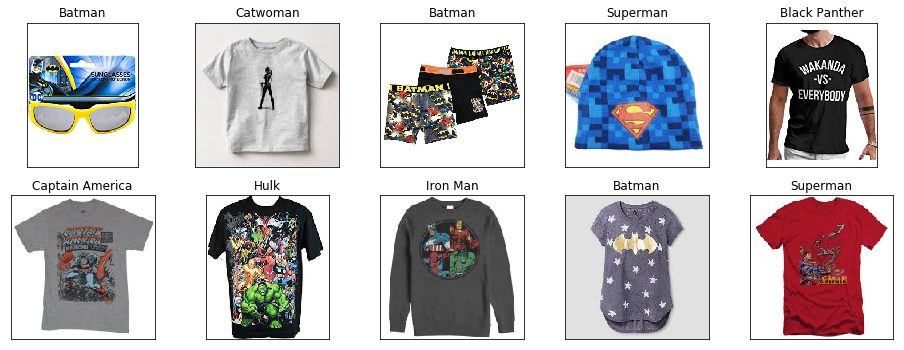

In [12]:
super_images_train.show(nimages=10, ncol=5, randomize=True)

In [13]:
super_images_train.label_freq # Check for Balance Across Labels

,Level,Frequency
Ant-Man,1,241
Aquaman,2,201
Avengers,3,216
Batman,4,779
Black Panther,5,460
Captain America,6,410
Catwoman,7,200
Ghost Rider,8,200
Hulk,9,414
Iron Man,10,694


In [14]:
super_images_train.image_summary # View Width and Height Min, Max, and Mean

jpg                  5433
minWidth               73
maxWidth              540
minHeight             120
maxHeight             522
meanWidth         197.982
meanHeight        230.795
mean1stChannel    167.516
min1stChannel           0
max1stChannel         255
mean2ndChannel     166.33
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    173.753
min3rdChannel           0
max3rdChannel         255
dtype: object

In [15]:
# Resize Train and Test Images
super_images_train.resize(width=224, height=224, inplace=True)
super_images_test.resize(width=224, height=224, inplace=True)

In [16]:
# Create Image Patches for Train Images
# CNN's View a Single Patch at a Time versus the Entire Image
super_images_train_patch = super_images_train.as_patches(width=200,
                                                         height=200,
                                                         step_size=24,
                                                         output_width=224,
                                                         output_height=224,
                                                         inplace=False)

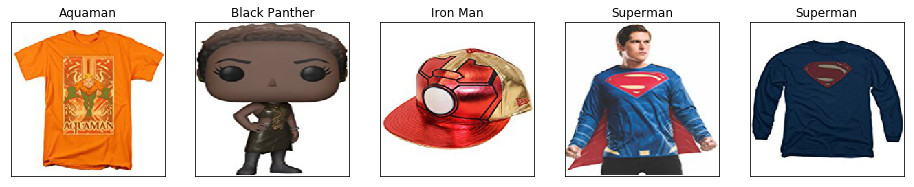

In [17]:
super_images_train.show(nimages=5, ncol=5, randomize=True) # Resized Images Preview

## Start Building Models with Initialized Weights

In [18]:
from dlpy.applications import *  # Get Pre-Trained Model Weights Out-of-the-Box
import os
pre_trained_weights_path = '/data/images/'

In [19]:
# Use Popular VGG16 Model
model_vgg16 = VGG16(
    conn,
    model_table='VGG16_notop',
    n_classes=12,
    n_channels=3,
    width=224,
    height=224,
    scale=1,
    offsets=(103.939, 116.779, 123.68),
    pre_train_weight=True, 
    pre_train_weight_file=os.path.join(pre_trained_weights_path, 'VGG_ILSVRC_16_layers.caffemodel.h5'),
    include_top=False)

NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16_notop" according to the model name in the table.


In [20]:
model_vgg16.print_summary() # VGG16 b/c 16 Layers with Weights

*==================*===============*========*============*=================*======================*
|   Layer (Type)   |  Kernel Size  | Stride | Activation |   Output Size   | Number of Parameters |
*------------------*---------------*--------*------------*-----------------*----------------------*
| data(Input)      |     None      |  None  |    None    |  (224, 224, 3)  |        0 / 0         |
| conv1_1(Convo.)  |    (3, 3)     |   1    | Rectifier  | (224, 224, 64)  |      1728 / 64       |
| conv1_2(Convo.)  |    (3, 3)     |   1    | Rectifier  | (224, 224, 64)  |      36864 / 64      |
| pool1(Pool)      |    (2, 2)     |   2    |    Max     | (112, 112, 64)  |        0 / 0         |
| conv2_1(Convo.)  |    (3, 3)     |   1    | Rectifier  | (112, 112, 128) |     73728 / 128      |
| conv2_2(Convo.)  |    (3, 3)     |   1    | Rectifier  | (112, 112, 128) |     147456 / 128     |
| pool2(Pool)      |    (2, 2)     |   2    |    Max     |  (56, 56, 128)  |        0 / 0         |


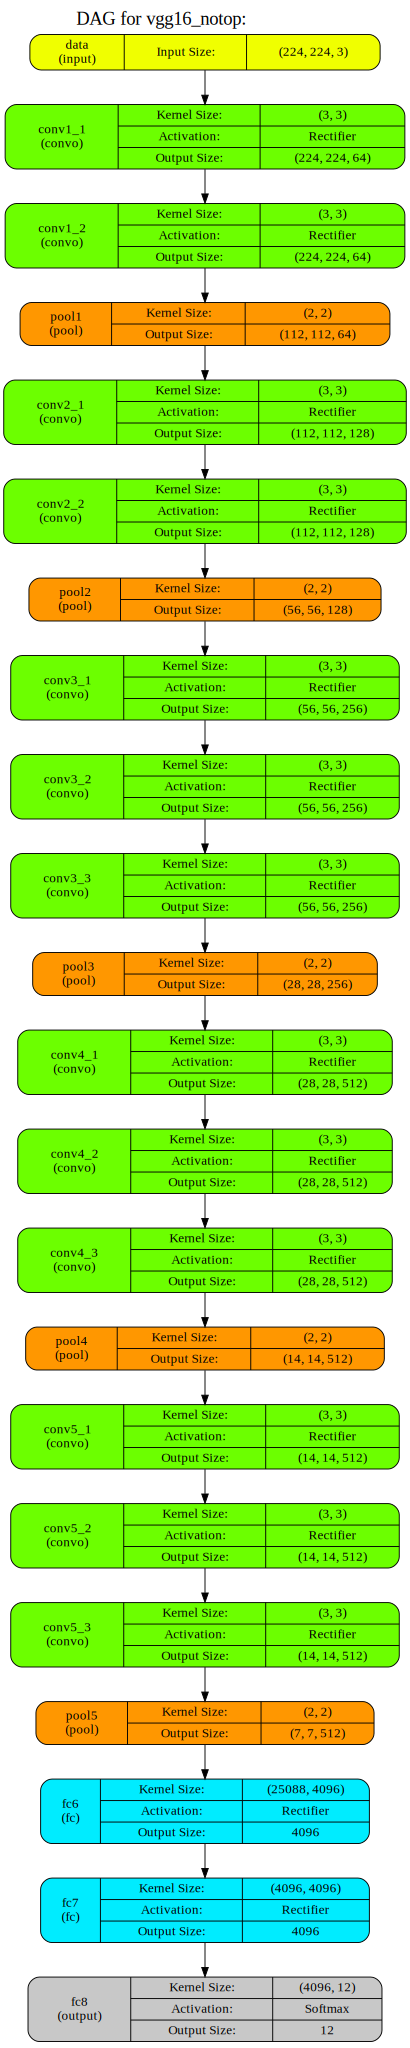

In [21]:
# Directed Acyclic Graph of Popular VGG16 Model Architecture
model_vgg16.plot_network()

In [22]:
# Batch of 32 Images per GPU
model_vgg16.fit(data=super_images_train_patch,
                mini_batch_size=32,
                max_epochs=20,
                lr=0.003,
                gpu=dict(devices=[0,1,2]), nthreads=3)

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 134309708.
NOTE:  The approximate memory cost is 1983.00 MB.
NOTE:  Loading weights cost       0.22 (s).
NOTE:  Initializing each layer cost       5.34 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total number of minibatch size per thread on each worker is 32.
NOTE:  The maximum number of minibatch size across all workers for the synchronous mode is 96.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     12
NOTE:  Levels for the target variable:
NOTE:  Level      0: Catwoman       
NOTE:  Level      1: Iron Man       
NOTE:  Level      2: Hulk           
NOTE:  Level      3: Ant-Man        
NOTE:  Level      4: Aquaman        
NOTE:  Level      5: Spiderman      
NOTE:  Level      6: Superman       
NOTE:  Level      7: Black Panther  
NOTE:  Level      8: Captain America
NOTE:  Level      9: Ghost Rider  

NOTE:       89               96   0.003          2.1854        0.75         0.46
NOTE:       90               96   0.003          2.0692      0.6979         0.46
NOTE:       91               96   0.003          2.1801      0.7188         0.46
NOTE:       92               96   0.003          2.2002      0.7708         0.46
NOTE:       93               96   0.003          2.0854      0.6979         0.46
NOTE:       94               96   0.003          2.1187      0.7292         0.46
NOTE:       95               96   0.003          1.9128      0.6354         0.46
NOTE:       96               96   0.003          2.2212      0.8021         0.46
NOTE:       97               96   0.003           2.129      0.7083         0.46
NOTE:       98               96   0.003          2.1351      0.6979         0.46
NOTE:       99               96   0.003          2.1781      0.8021         0.46
NOTE:      100               96   0.003          2.1408      0.7292         0.46
NOTE:      101              

NOTE:      192               96   0.003          2.2226      0.7188         0.47
NOTE:      193               96   0.003          1.7028      0.5313         0.47
NOTE:      194               96   0.003          1.7093      0.5313         0.47
NOTE:      195               96   0.003          1.9151      0.5729         0.47
NOTE:      196               96   0.003          1.6665         0.5         0.47
NOTE:      197               96   0.003          1.7695      0.5521         0.46
NOTE:      198               96   0.003          1.8188      0.5625         0.47
NOTE:      199               96   0.003          1.6386         0.5         0.47
NOTE:      200               96   0.003          1.8048      0.5625         0.47
NOTE:      201               96   0.003          1.7899      0.5833         0.47
NOTE:      202               96   0.003          1.6566       0.625         0.47
NOTE:      203               96   0.003          1.7107      0.5729         0.47
NOTE:      204              

NOTE:       65               96   0.003          1.4139      0.4167         0.47
NOTE:       66               96   0.003           1.535      0.5208         0.47
NOTE:       67               96   0.003          1.2714      0.4167         0.47
NOTE:       68               96   0.003          1.2062      0.3958         0.47
NOTE:       69               96   0.003          1.3917      0.4375         0.47
NOTE:       70               96   0.003          1.3982      0.4271         0.47
NOTE:       71               96   0.003           1.474         0.5         0.47
NOTE:       72               96   0.003          1.4198      0.4583         0.47
NOTE:       73               96   0.003          1.6047      0.5208         0.47
NOTE:       74               96   0.003          1.2589      0.4063         0.47
NOTE:       75               96   0.003          1.1836      0.3333         0.47
NOTE:       76               96   0.003          1.2508      0.4271         0.47
NOTE:       77              

NOTE:      171               96   0.003          1.2209       0.375         0.47
NOTE:      172               96   0.003          0.9619      0.3229         0.47
NOTE:      173               96   0.003           1.164      0.3854         0.47
NOTE:      174               96   0.003          1.0243      0.3229         0.47
NOTE:      175               96   0.003          1.2396      0.3958         0.47
NOTE:      176               96   0.003          1.1804      0.3229         0.47
NOTE:      177               96   0.003          0.7955      0.1979         0.47
NOTE:      178               96   0.003           0.917      0.3646         0.47
NOTE:      179               96   0.003          0.8895      0.2708         0.47
NOTE:      180               96   0.003          0.9992      0.3021         0.47
NOTE:      181               96   0.003          1.1485      0.4167         0.47
NOTE:      182               96   0.003          0.9221      0.3333         0.47
NOTE:      183              

NOTE:       45               96   0.003          0.7883      0.2813         0.47
NOTE:       46               96   0.003          0.7607      0.2708         0.47
NOTE:       47               96   0.003          0.9705      0.2813         0.47
NOTE:       48               96   0.003          0.8472      0.3229         0.47
NOTE:       49               96   0.003          0.7748      0.2292         0.47
NOTE:       50               96   0.003          0.6612      0.1771         0.47
NOTE:       51               96   0.003          0.6948      0.2604         0.47
NOTE:       52               96   0.003          0.8734      0.2604         0.47
NOTE:       53               96   0.003          0.8401      0.3125         0.47
NOTE:       54               96   0.003          0.8973      0.3125         0.47
NOTE:       55               96   0.003          0.7421      0.2083         0.47
NOTE:       56               96   0.003          0.8783      0.3229         0.47
NOTE:       57              

NOTE:      152               96   0.003          0.6591      0.2292         0.47
NOTE:      153               96   0.003            0.69      0.1979         0.47
NOTE:      154               96   0.003          0.7704      0.2292         0.47
NOTE:      155               96   0.003          0.6738      0.2292         0.48
NOTE:      156               96   0.003          0.8276        0.25         0.47
NOTE:      157               96   0.003          0.6418      0.1563         0.47
NOTE:      158               96   0.003          0.7008      0.1667         0.47
NOTE:      159               96   0.003          0.7031      0.1667         0.47
NOTE:      160               96   0.003          0.6099      0.1563         0.48
NOTE:      161               96   0.003          0.5321      0.1771         0.47
NOTE:      162               96   0.003          0.8417        0.25         0.47
NOTE:      163               96   0.003          0.6161      0.2083         0.47
NOTE:      164              

NOTE:       26               96   0.003          0.4594      0.1354         0.47
NOTE:       27               96   0.003          0.3575      0.1354         0.47
NOTE:       28               96   0.003          0.4994      0.1667         0.47
NOTE:       29               96   0.003          0.4605       0.125         0.47
NOTE:       30               96   0.003          0.6624      0.2292         0.47
NOTE:       31               96   0.003          0.6315      0.1771         0.47
NOTE:       32               96   0.003          0.6377      0.2396         0.47
NOTE:       33               96   0.003          0.5962      0.2083         0.48
NOTE:       34               96   0.003          0.4757      0.1667         0.47
NOTE:       35               96   0.003          0.5623      0.1667         0.46
NOTE:       36               96   0.003           0.454      0.1354         0.47
NOTE:       37               96   0.003          0.5976      0.1667         0.48
NOTE:       38              

NOTE:      130               96   0.003          0.3981      0.0938         0.47
NOTE:      131               96   0.003          0.4411      0.1354         0.47
NOTE:      132               96   0.003          0.4118      0.1146         0.47
NOTE:      133               96   0.003           0.538      0.1458         0.47
NOTE:      134               96   0.003          0.5736      0.1667         0.47
NOTE:      135               96   0.003          0.5742      0.1979         0.47
NOTE:      136               96   0.003          0.4816       0.125         0.47
NOTE:      137               96   0.003          0.4275      0.1354         0.47
NOTE:      138               96   0.003          0.3576      0.1042         0.47
NOTE:      139               96   0.003          0.3447      0.1042         0.47
NOTE:      140               96   0.003          0.4874      0.1563         0.47
NOTE:      141               96   0.003          0.4359       0.125         0.47
NOTE:      142              

NOTE:        4               96   0.003          0.5105      0.1667         0.48
NOTE:        5               96   0.003          0.3093       0.125         0.47
NOTE:        6               96   0.003          0.3115      0.0938         0.47
NOTE:        7               96   0.003          0.3691      0.1354         0.47
NOTE:        8               96   0.003           0.288      0.0833         0.47
NOTE:        9               96   0.003          0.4242      0.1563         0.47
NOTE:       10               96   0.003          0.5288      0.1563         0.47
NOTE:       11               96   0.003          0.2665      0.0833         0.47
NOTE:       12               96   0.003          0.2626      0.0729         0.47
NOTE:       13               96   0.003          0.2513      0.0938         0.47
NOTE:       14               96   0.003          0.2376      0.0625         0.47
NOTE:       15               96   0.003          0.2797      0.0729         0.47
NOTE:       16              

NOTE:      106               96   0.003          0.2178      0.0625         0.47
NOTE:      107               96   0.003           0.145      0.0417         0.47
NOTE:      108               96   0.003           0.392      0.1146         0.47
NOTE:      109               96   0.003          0.3464      0.0938         0.47
NOTE:      110               96   0.003           0.226      0.0833         0.47
NOTE:      111               96   0.003          0.4073      0.1354         0.47
NOTE:      112               96   0.003          0.2966      0.0833         0.47
NOTE:      113               96   0.003          0.2314      0.0833         0.47
NOTE:      114               96   0.003          0.3681       0.125         0.47
NOTE:      115               96   0.003           0.184      0.0625         0.47
NOTE:      116               96   0.003          0.2402      0.0833         0.47
NOTE:      117               96   0.003          0.3248       0.125         0.47
NOTE:      118              

NOTE:      213               96   0.003          0.3031      0.1146         0.47
NOTE:      214               96   0.003          0.5094      0.1354         0.47
NOTE:      215               96   0.003          0.2952      0.0938         0.47
NOTE:      216               96   0.003          0.2562      0.0833         0.47
NOTE:      217               96   0.003          0.4132      0.1458         0.47
NOTE:      218               96   0.003          0.3646      0.0938         0.47
NOTE:      219               96   0.003          0.4454      0.1458         0.47
NOTE:      220               96   0.003          0.4043      0.1042         0.47
NOTE:      221               96   0.003          0.1922      0.0729         0.47
NOTE:      222               96   0.003          0.3104      0.1146         0.47
NOTE:      223               96   0.003          0.4537      0.1458         0.47
NOTE:      224               96   0.003          0.3961       0.125         0.47
NOTE:      225              

NOTE:       88               96   0.003          0.2862      0.0521         0.47
NOTE:       89               96   0.003           0.301      0.1146         0.47
NOTE:       90               96   0.003          0.4049      0.1042         0.47
NOTE:       91               96   0.003          0.3802      0.1042         0.47
NOTE:       92               96   0.003          0.3481      0.1458         0.47
NOTE:       93               96   0.003          0.2461      0.0833         0.47
NOTE:       94               96   0.003          0.2012      0.0625         0.47
NOTE:       95               96   0.003           0.169      0.0729         0.47
NOTE:       96               96   0.003          0.1523      0.0729         0.47
NOTE:       97               96   0.003          0.2199      0.0833         0.47
NOTE:       98               96   0.003          0.2225      0.1042         0.47
NOTE:       99               96   0.003            0.33      0.0938         0.47
NOTE:      100              

NOTE:      197               96   0.003          0.3833      0.1146         0.47
NOTE:      198               96   0.003          0.2855      0.1042         0.47
NOTE:      199               96   0.003          0.2343      0.0521         0.47
NOTE:      200               96   0.003          0.2127      0.0833         0.47
NOTE:      201               96   0.003          0.2834      0.1042         0.47
NOTE:      202               96   0.003          0.3327      0.0938         0.47
NOTE:      203               96   0.003          0.2568      0.0833         0.47
NOTE:      204               96   0.003            0.34      0.1042         0.47
NOTE:      205               96   0.003          0.2076      0.0521         0.47
NOTE:      206               96   0.003          0.1677      0.0417         0.47
NOTE:      207               96   0.003          0.0931      0.0208         0.47
NOTE:      208               96   0.003          0.1956      0.0729         0.47
NOTE:      209              

NOTE:       73               96   0.003          0.0628      0.0208         0.47
NOTE:       74               96   0.003          0.2203      0.0625         0.47
NOTE:       75               96   0.003           0.063      0.0208         0.47
NOTE:       76               96   0.003          0.0615      0.0104         0.48
NOTE:       77               96   0.003          0.1201      0.0313         0.47
NOTE:       78               96   0.003          0.0951      0.0313         0.48
NOTE:       79               96   0.003          0.1982      0.0729         0.47
NOTE:       80               96   0.003          0.1489      0.0729         0.47
NOTE:       81               96   0.003          0.1248      0.0313         0.47
NOTE:       82               96   0.003          0.1096      0.0521         0.47
NOTE:       83               96   0.003          0.0883      0.0417         0.47
NOTE:       84               96   0.003            0.08      0.0313         0.47
NOTE:       85              

NOTE:      175               96   0.003          0.1204      0.0313         0.47
NOTE:      176               96   0.003          0.1704      0.0625         0.47
NOTE:      177               96   0.003          0.0967      0.0521         0.47
NOTE:      178               96   0.003          0.0978      0.0208         0.47
NOTE:      179               96   0.003          0.0687      0.0208         0.47
NOTE:      180               96   0.003          0.0364           0         0.47
NOTE:      181               96   0.003          0.0441      0.0208         0.47
NOTE:      182               96   0.003          0.1156      0.0625         0.47
NOTE:      183               96   0.003          0.1272      0.0208         0.47
NOTE:      184               96   0.003            0.17      0.0521         0.47
NOTE:      185               96   0.003          0.1286      0.0521         0.47
NOTE:      186               96   0.003          0.1436      0.0521         0.47
NOTE:      187              

NOTE:       47               96   0.003          0.0542      0.0208         0.47
NOTE:       48               96   0.003          0.1397      0.0625         0.47
NOTE:       49               96   0.003          0.0926      0.0521         0.47
NOTE:       50               96   0.003          0.0641      0.0104         0.47
NOTE:       51               96   0.003          0.0858      0.0208         0.47
NOTE:       52               96   0.003          0.1191      0.0521         0.47
NOTE:       53               96   0.003          0.0483      0.0208         0.47
NOTE:       54               96   0.003          0.0742      0.0208         0.47
NOTE:       55               96   0.003          0.0655      0.0104         0.48
NOTE:       56               96   0.003          0.1671      0.0625         0.47
NOTE:       57               96   0.003           0.172      0.0833         0.47
NOTE:       58               96   0.003          0.0597           0         0.47
NOTE:       59              

NOTE:      153               96   0.003          0.0853      0.0313         0.47
NOTE:      154               96   0.003          0.1474      0.0208         0.47
NOTE:      155               96   0.003          0.0344      0.0104         0.47
NOTE:      156               96   0.003          0.0954      0.0313         0.47
NOTE:      157               96   0.003          0.0744      0.0104         0.47
NOTE:      158               96   0.003          0.0753      0.0417         0.47
NOTE:      159               96   0.003          0.0789      0.0104         0.48
NOTE:      160               96   0.003          0.0261           0         0.48
NOTE:      161               96   0.003           0.069      0.0208         0.47
NOTE:      162               96   0.003          0.0786      0.0313         0.47
NOTE:      163               96   0.003          0.1527      0.0417         0.47
NOTE:      164               96   0.003          0.1167      0.0313         0.47
NOTE:      165              

NOTE:       33               96   0.003          0.1715      0.0625         0.47
NOTE:       34               96   0.003          0.0427           0         0.47
NOTE:       35               96   0.003          0.0426      0.0104         0.47
NOTE:       36               96   0.003          0.0998      0.0104         0.47
NOTE:       37               96   0.003          0.1046      0.0208         0.47
NOTE:       38               96   0.003          0.0489      0.0104         0.47
NOTE:       39               96   0.003          0.0809      0.0417         0.48
NOTE:       40               96   0.003          0.0887      0.0208         0.47
NOTE:       41               96   0.003          0.1432      0.0521         0.47
NOTE:       42               96   0.003          0.0749      0.0208         0.47
NOTE:       43               96   0.003          0.0549      0.0104         0.47
NOTE:       44               96   0.003          0.0498      0.0104         0.47
NOTE:       45              

NOTE:      135               96   0.003          0.1711      0.0521         0.48
NOTE:      136               96   0.003           0.267      0.0417         0.47
NOTE:      137               96   0.003          0.0512      0.0104         0.47
NOTE:      138               96   0.003          0.1182      0.0313         0.47
NOTE:      139               96   0.003          0.0536      0.0104         0.47
NOTE:      140               96   0.003          0.0534      0.0104         0.47
NOTE:      141               96   0.003          0.0249      0.0104         0.47
NOTE:      142               96   0.003          0.0557      0.0208         0.47
NOTE:      143               96   0.003          0.1415      0.0417         0.47
NOTE:      144               96   0.003          0.0367      0.0104         0.47
NOTE:      145               96   0.003           0.049      0.0208         0.47
NOTE:      146               96   0.003          0.0176           0         0.47
NOTE:      147              

NOTE:        9               96   0.003          0.0674      0.0313         0.47
NOTE:       10               96   0.003          0.0335      0.0104         0.48
NOTE:       11               96   0.003          0.0408      0.0104         0.47
NOTE:       12               96   0.003          0.0263      0.0104         0.47
NOTE:       13               96   0.003          0.0516      0.0104         0.47
NOTE:       14               96   0.003          0.0202           0         0.47
NOTE:       15               96   0.003          0.0326      0.0104         0.47
NOTE:       16               96   0.003          0.0743      0.0104         0.47
NOTE:       17               96   0.003          0.1071      0.0313         0.47
NOTE:       18               96   0.003          0.0901      0.0417         0.47
NOTE:       19               96   0.003          0.0457      0.0104         0.47
NOTE:       20               96   0.003          0.0545      0.0104         0.47
NOTE:       21              

NOTE:      114               96   0.003          0.0343      0.0104         0.47
NOTE:      115               96   0.003          0.0105           0         0.47
NOTE:      116               96   0.003          0.0182      0.0104         0.47
NOTE:      117               96   0.003          0.0433      0.0104         0.47
NOTE:      118               96   0.003          0.0145           0         0.47
NOTE:      119               96   0.003          0.0369      0.0104         0.47
NOTE:      120               96   0.003          0.1114      0.0313         0.47
NOTE:      121               96   0.003          0.0964      0.0208         0.47
NOTE:      122               96   0.003          0.1901      0.0417         0.47
NOTE:      123               96   0.003          0.0405      0.0104         0.47
NOTE:      124               96   0.003          0.0306           0         0.47
NOTE:      125               96   0.003           0.068      0.0104         0.47
NOTE:      126              

NOTE:      216               96   0.003          0.0242           0         0.47
NOTE:      217               96   0.003          0.1086      0.0313         0.47
NOTE:      218               96   0.003          0.0283      0.0104         0.47
NOTE:      219               96   0.003          0.0862      0.0208         0.47
NOTE:      220               96   0.003          0.0957      0.0313         0.47
NOTE:      221               96   0.003          0.0293      0.0104         0.47
NOTE:      222               96   0.003          0.0152           0         0.48
NOTE:      223               96   0.003          0.0459      0.0208         0.48
NOTE:      224               96   0.003          0.0897      0.0313         0.47
NOTE:      225               96   0.003           0.093      0.0313         0.48
NOTE:      226               36   0.003          0.0232           0         0.25
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:          9           0.003    

NOTE:       89               96   0.003           0.067      0.0104         0.47
NOTE:       90               96   0.003          0.0461      0.0104         0.47
NOTE:       91               96   0.003          0.0082           0         0.47
NOTE:       92               96   0.003          0.0742      0.0208         0.47
NOTE:       93               96   0.003           0.053      0.0208         0.47
NOTE:       94               96   0.003          0.0357      0.0104         0.47
NOTE:       95               96   0.003          0.0245      0.0104         0.47
NOTE:       96               96   0.003          0.0137           0         0.47
NOTE:       97               96   0.003          0.0145           0         0.47
NOTE:       98               96   0.003          0.0185           0         0.47
NOTE:       99               96   0.003          0.0347      0.0104         0.47
NOTE:      100               96   0.003          0.0103           0         0.47
NOTE:      101              

NOTE:      196               96   0.003          0.0105           0         0.48
NOTE:      197               96   0.003          0.0166           0         0.48
NOTE:      198               96   0.003          0.0262           0         0.47
NOTE:      199               96   0.003          0.1026      0.0208         0.47
NOTE:      200               96   0.003          0.0753      0.0104         0.48
NOTE:      201               96   0.003          0.0061           0         0.47
NOTE:      202               96   0.003          0.0117           0         0.47
NOTE:      203               96   0.003          0.0339      0.0104         0.47
NOTE:      204               96   0.003          0.1464      0.0313         0.47
NOTE:      205               96   0.003          0.0608      0.0208         0.47
NOTE:      206               96   0.003          0.0404      0.0208         0.47
NOTE:      207               96   0.003           0.081      0.0208         0.47
NOTE:      208              

NOTE:       73               96   0.003          0.0351      0.0104         0.47
NOTE:       74               96   0.003          0.0761      0.0208         0.47
NOTE:       75               96   0.003          0.0091           0         0.48
NOTE:       76               96   0.003          0.0224           0         0.47
NOTE:       77               96   0.003          0.0328      0.0104         0.47
NOTE:       78               96   0.003          0.0515      0.0104         0.48
NOTE:       79               96   0.003          0.0444      0.0208         0.47
NOTE:       80               96   0.003          0.0053           0         0.47
NOTE:       81               96   0.003          0.0148           0         0.47
NOTE:       82               96   0.003          0.0097           0         0.47
NOTE:       83               96   0.003          0.0868      0.0104         0.47
NOTE:       84               96   0.003           0.016      0.0104         0.47
NOTE:       85              

NOTE:      177               96   0.003          0.0175           0         0.47
NOTE:      178               96   0.003          0.0075           0         0.47
NOTE:      179               96   0.003          0.0045           0         0.47
NOTE:      180               96   0.003          0.0027           0         0.47
NOTE:      181               96   0.003          0.0037           0         0.47
NOTE:      182               96   0.003            0.01           0         0.47
NOTE:      183               96   0.003          0.0068           0         0.47
NOTE:      184               96   0.003          0.0779      0.0104         0.47
NOTE:      185               96   0.003          0.0216      0.0104         0.47
NOTE:      186               96   0.003          0.0449      0.0104         0.48
NOTE:      187               96   0.003          0.0054           0         0.47
NOTE:      188               96   0.003          0.0035           0         0.47
NOTE:      189              

NOTE:       51               96   0.003          0.0291      0.0104         0.47
NOTE:       52               96   0.003          0.0516      0.0104         0.47
NOTE:       53               96   0.003          0.0309      0.0104         0.47
NOTE:       54               96   0.003          0.0356           0         0.47
NOTE:       55               96   0.003          0.0352      0.0104         0.47
NOTE:       56               96   0.003          0.0296      0.0104         0.47
NOTE:       57               96   0.003          0.0319      0.0104         0.47
NOTE:       58               96   0.003          0.0212           0         0.47
NOTE:       59               96   0.003          0.0805      0.0208         0.47
NOTE:       60               96   0.003          0.0687      0.0104         0.47
NOTE:       61               96   0.003          0.0229      0.0104         0.47
NOTE:       62               96   0.003          0.0429      0.0104         0.47
NOTE:       63              

NOTE:      156               96   0.003           0.038      0.0208         0.47
NOTE:      157               96   0.003          0.0709      0.0208         0.47
NOTE:      158               96   0.003          0.0551      0.0208         0.47
NOTE:      159               96   0.003          0.1062      0.0104         0.47
NOTE:      160               96   0.003          0.0123           0         0.47
NOTE:      161               96   0.003           0.019           0         0.47
NOTE:      162               96   0.003          0.0124           0         0.47
NOTE:      163               96   0.003          0.0308      0.0104         0.48
NOTE:      164               96   0.003          0.0062           0         0.47
NOTE:      165               96   0.003          0.0053           0         0.47
NOTE:      166               96   0.003          0.0077           0         0.47
NOTE:      167               96   0.003          0.0449      0.0104         0.47
NOTE:      168              

NOTE:       29               96   0.003          0.0226      0.0104         0.48
NOTE:       30               96   0.003          0.0157      0.0104         0.47
NOTE:       31               96   0.003          0.0053           0         0.47
NOTE:       32               96   0.003          0.0594      0.0104         0.47
NOTE:       33               96   0.003          0.0748      0.0208         0.47
NOTE:       34               96   0.003          0.0106      0.0104         0.47
NOTE:       35               96   0.003          0.0052           0         0.47
NOTE:       36               96   0.003          0.0082           0         0.47
NOTE:       37               96   0.003          0.0556      0.0104         0.47
NOTE:       38               96   0.003          0.0304      0.0104         0.48
NOTE:       39               96   0.003          0.0098           0         0.47
NOTE:       40               96   0.003          0.0835      0.0104         0.47
NOTE:       41              

NOTE:      133               96   0.003          0.0042           0         0.47
NOTE:      134               96   0.003           0.012           0         0.47
NOTE:      135               96   0.003          0.0304      0.0208         0.47
NOTE:      136               96   0.003          0.0067           0         0.47
NOTE:      137               96   0.003          0.0101           0         0.47
NOTE:      138               96   0.003          0.0528      0.0104         0.47
NOTE:      139               96   0.003          0.0291      0.0104         0.47
NOTE:      140               96   0.003          0.0214           0         0.47
NOTE:      141               96   0.003           0.012           0         0.47
NOTE:      142               96   0.003          0.0186           0         0.47
NOTE:      143               96   0.003          0.0455      0.0208         0.47
NOTE:      144               96   0.003          0.0091           0         0.47
NOTE:      145              

NOTE:       10               96   0.003          0.0231      0.0104         0.48
NOTE:       11               96   0.003          0.0051           0         0.47
NOTE:       12               96   0.003          0.0171           0         0.47
NOTE:       13               96   0.003          0.0639      0.0208         0.47
NOTE:       14               96   0.003          0.0416      0.0104         0.47
NOTE:       15               96   0.003          0.0441      0.0104         0.47
NOTE:       16               96   0.003          0.0219           0         0.48
NOTE:       17               96   0.003          0.0398      0.0104         0.47
NOTE:       18               96   0.003          0.0669      0.0104         0.47
NOTE:       19               96   0.003          0.0127           0         0.47
NOTE:       20               96   0.003          0.0996      0.0104         0.47
NOTE:       21               96   0.003          0.0027           0         0.47
NOTE:       22              

NOTE:      116               96   0.003          0.0037           0         0.47
NOTE:      117               96   0.003           0.014           0         0.47
NOTE:      118               96   0.003          0.0297      0.0104         0.47
NOTE:      119               96   0.003          0.0066           0         0.47
NOTE:      120               96   0.003          0.0435      0.0104         0.48
NOTE:      121               96   0.003          0.0649      0.0208         0.47
NOTE:      122               96   0.003          0.0213      0.0104         0.47
NOTE:      123               96   0.003          0.0078           0         0.47
NOTE:      124               96   0.003          0.0183      0.0104         0.47
NOTE:      125               96   0.003          0.0693      0.0208         0.47
NOTE:      126               96   0.003          0.0059           0         0.47
NOTE:      127               96   0.003           0.012           0         0.47
NOTE:      128              

NOTE:      223               96   0.003          0.0113           0         0.47
NOTE:      224               96   0.003          0.0023           0         0.47
NOTE:      225               96   0.003          0.0901      0.0208         0.47
NOTE:      226               36   0.003          0.0614      0.0278         0.25
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         14           0.003       0.0276     0.0078       106.80
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      Time (s) (Training)
NOTE:        0               96   0.003          0.1115      0.0521         0.52
NOTE:        1               96   0.003          0.1689      0.0625         0.47
NOTE:        2               96   0.003          0.0929      0.0208         0.47
NOTE:        3               96   0.003          0.0425      0.0208         0.47
NOTE:        4               96   0.003          0.0555      0.0208         0.47
NOTE:        5               96  

NOTE:       97               96   0.003          0.0138           0         0.48
NOTE:       98               96   0.003          0.0663      0.0313         0.47
NOTE:       99               96   0.003          0.1241      0.0313         0.47
NOTE:      100               96   0.003          0.0064           0         0.47
NOTE:      101               96   0.003           0.014      0.0104         0.48
NOTE:      102               96   0.003          0.1257      0.0208         0.47
NOTE:      103               96   0.003          0.0211      0.0104         0.47
NOTE:      104               96   0.003          0.0257      0.0208         0.47
NOTE:      105               96   0.003          0.0186           0         0.47
NOTE:      106               96   0.003          0.0074           0         0.47
NOTE:      107               96   0.003          0.0168           0         0.47
NOTE:      108               96   0.003          0.0066           0         0.47
NOTE:      109              

NOTE:      201               96   0.003          0.0082           0         0.47
NOTE:      202               96   0.003          0.0104           0         0.47
NOTE:      203               96   0.003          0.0414      0.0208         0.48
NOTE:      204               96   0.003          0.0457      0.0208         0.47
NOTE:      205               96   0.003          0.0076           0         0.47
NOTE:      206               96   0.003          0.0207      0.0104         0.48
NOTE:      207               96   0.003          0.0074           0         0.47
NOTE:      208               96   0.003          0.0306      0.0104         0.47
NOTE:      209               96   0.003          0.0185           0         0.47
NOTE:      210               96   0.003          0.0234      0.0104         0.47
NOTE:      211               96   0.003          0.0049           0         0.47
NOTE:      212               96   0.003          0.0111           0         0.47
NOTE:      213              

NOTE:       73               96   0.003          0.0201      0.0104         0.47
NOTE:       74               96   0.003          0.0384      0.0208         0.47
NOTE:       75               96   0.003          0.0039           0         0.47
NOTE:       76               96   0.003          0.0209      0.0104         0.47
NOTE:       77               96   0.003          0.0045           0         0.47
NOTE:       78               96   0.003          0.0057           0         0.47
NOTE:       79               96   0.003          0.0546      0.0313         0.46
NOTE:       80               96   0.003          0.0044           0         0.47
NOTE:       81               96   0.003           0.003           0         0.47
NOTE:       82               96   0.003          0.0052           0         0.47
NOTE:       83               96   0.003          0.0131           0         0.47
NOTE:       84               96   0.003          0.0013           0         0.47
NOTE:       85              

NOTE:      181               96   0.003          0.0028           0         0.47
NOTE:      182               96   0.003          0.0078           0         0.47
NOTE:      183               96   0.003          0.0039           0         0.47
NOTE:      184               96   0.003          0.0464      0.0208         0.47
NOTE:      185               96   0.003          0.0479      0.0104         0.47
NOTE:      186               96   0.003          0.0288      0.0104         0.48
NOTE:      187               96   0.003          0.0046           0         0.47
NOTE:      188               96   0.003          0.0031           0         0.47
NOTE:      189               96   0.003          0.0092      0.0104         0.47
NOTE:      190               96   0.003          0.0511      0.0208         0.47
NOTE:      191               96   0.003          0.0803      0.0313         0.47
NOTE:      192               96   0.003          0.0082           0         0.47
NOTE:      193              

NOTE:       55               96   0.003          0.0446      0.0104         0.47
NOTE:       56               96   0.003          0.0061           0         0.47
NOTE:       57               96   0.003          0.0105           0         0.47
NOTE:       58               96   0.003          0.0231      0.0104         0.47
NOTE:       59               96   0.003          0.0021           0         0.47
NOTE:       60               96   0.003          0.0392      0.0104         0.47
NOTE:       61               96   0.003          0.1118      0.0104         0.48
NOTE:       62               96   0.003          0.0263      0.0104         0.47
NOTE:       63               96   0.003          0.0425      0.0208         0.47
NOTE:       64               96   0.003          0.0092           0         0.48
NOTE:       65               96   0.003          0.0133      0.0104         0.47
NOTE:       66               96   0.003          0.0196      0.0104         0.47
NOTE:       67              

NOTE:      161               96   0.003          0.0031           0         0.47
NOTE:      162               96   0.003          0.0125           0         0.47
NOTE:      163               96   0.003          0.0221           0         0.47
NOTE:      164               96   0.003          0.0043           0         0.47
NOTE:      165               96   0.003          0.0042           0         0.47
NOTE:      166               96   0.003          0.0033           0         0.47
NOTE:      167               96   0.003          0.0243      0.0104         0.48
NOTE:      168               96   0.003           0.004           0         0.47
NOTE:      169               96   0.003            0.03      0.0104         0.47
NOTE:      170               96   0.003          0.0068           0         0.47
NOTE:      171               96   0.003          0.0173      0.0104         0.48
NOTE:      172               96   0.003          0.0043           0         0.47
NOTE:      173              

NOTE:       34               96   0.003          0.0055           0         0.48
NOTE:       35               96   0.003          0.0086           0         0.47
NOTE:       36               96   0.003          0.0183      0.0104         0.47
NOTE:       37               96   0.003          0.0089           0         0.47
NOTE:       38               96   0.003          0.0162      0.0104         0.48
NOTE:       39               96   0.003          0.0094           0         0.47
NOTE:       40               96   0.003          0.0061           0         0.47
NOTE:       41               96   0.003            0.01           0         0.47
NOTE:       42               96   0.003          0.0123           0         0.47
NOTE:       43               96   0.003          0.0031           0         0.47
NOTE:       44               96   0.003          0.0289      0.0104         0.48
NOTE:       45               96   0.003          0.0415      0.0104         0.48
NOTE:       46              

NOTE:      140               96   0.003          0.0037           0         0.47
NOTE:      141               96   0.003          0.0026           0         0.47
NOTE:      142               96   0.003          0.0147      0.0104         0.47
NOTE:      143               96   0.003          0.0539      0.0104         0.48
NOTE:      144               96   0.003          0.0023           0         0.47
NOTE:      145               96   0.003          0.0785      0.0208         0.47
NOTE:      146               96   0.003          0.0037           0         0.47
NOTE:      147               96   0.003          0.0063           0         0.48
NOTE:      148               96   0.003          0.0035           0         0.47
NOTE:      149               96   0.003          0.0065           0         0.47
NOTE:      150               96   0.003          0.0283      0.0104         0.47
NOTE:      151               96   0.003          0.0096      0.0104         0.47
NOTE:      152              

NOTE:       16               96   0.003           0.024      0.0104         0.47
NOTE:       17               96   0.003          0.0222      0.0104         0.47
NOTE:       18               96   0.003          0.0293      0.0313         0.47
NOTE:       19               96   0.003          0.0046           0         0.47
NOTE:       20               96   0.003          0.0076           0         0.47
NOTE:       21               96   0.003          0.0012           0         0.47
NOTE:       22               96   0.003           0.039      0.0104         0.47
NOTE:       23               96   0.003          0.0065           0         0.47
NOTE:       24               96   0.003          0.0136      0.0104         0.47
NOTE:       25               96   0.003          0.0086           0         0.47
NOTE:       26               96   0.003          0.0045           0         0.47
NOTE:       27               96   0.003          0.0161      0.0104         0.47
NOTE:       28              

NOTE:      118               96   0.003          0.0013           0         0.47
NOTE:      119               96   0.003          0.0017           0         0.47
NOTE:      120               96   0.003          0.0421      0.0104         0.48
NOTE:      121               96   0.003            0.04      0.0208         0.47
NOTE:      122               96   0.003          0.0021           0         0.47
NOTE:      123               96   0.003          0.0137      0.0104         0.47
NOTE:      124               96   0.003          0.0014           0         0.48
NOTE:      125               96   0.003          0.0161      0.0104         0.48
NOTE:      126               96   0.003          0.0046           0         0.47
NOTE:      127               96   0.003          0.0156      0.0104         0.47
NOTE:      128               96   0.003          0.0187      0.0104         0.47
NOTE:      129               96   0.003          0.0028           0         0.47
NOTE:      130              

NOTE:      223               96   0.003          0.0112           0         0.48
NOTE:      224               96   0.003          0.0033           0         0.47
NOTE:      225               96   0.003          0.0095           0         0.47
NOTE:      226               36   0.003          0.0009           0         0.26
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:         19           0.003        0.018      0.006       106.94
NOTE:  The optimization reached the maximum number of epochs.
NOTE:  The total time is    2135.20 (s).


,Descr,Value
0,Model Name,vgg16_notop
1,Model Type,Convolutional Neural Network
2,Number of Layers,22
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,13
6,Number of Pooling Layers,5
7,Number of Fully Connected Layers,2
8,Number of Weight Parameters,134297280
9,Number of Bias Parameters,12428


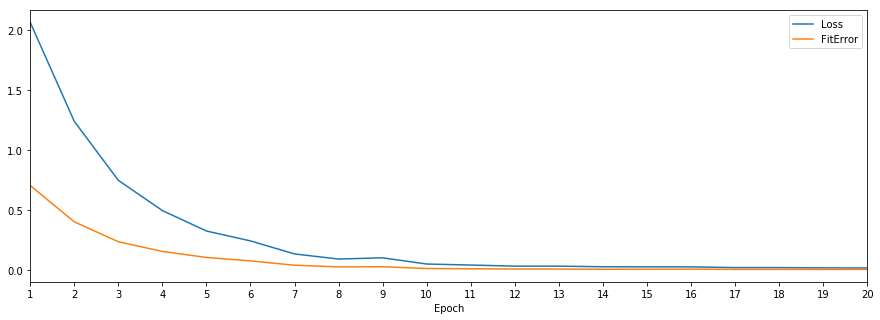

In [23]:
# Loss and Fit Error Over Epochs
model_vgg16.plot_training_history(fig_size=(15, 5))

In [24]:
# Overall Training Error
model_vgg16.predict(data=super_images_train)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          5433
 1  Number of Observations Used          5433
 2  Misclassification Error (%)      1.325235
 3                   Loss Error      0.047195

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_6XCUen  5433       18   
 
                                             casTable  
 0  CASTable('Valid_Res_6XCUen', caslib='CASUSER(s...  

+ Elapsed: 491s, user: 5.67e+03s, sys: 42.2s, mem: 9.5e+03mb

## Applying our CNN Model to Test Data

In [25]:
# Overall Test Error (However, our Test Data is not Labeled)
model_vgg16.predict(data=super_images_test)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          3375
 1  Number of Observations Used          3375
 2  Misclassification Error (%)           100
 3                   Loss Error             0

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_z4s89I  3375       18   
 
                                             casTable  
 0  CASTable('Valid_Res_z4s89I', caslib='CASUSER(s...  

+ Elapsed: 307s, user: 3.53e+03s, sys: 30.9s, mem: 9.49e+03mb

View Predictions

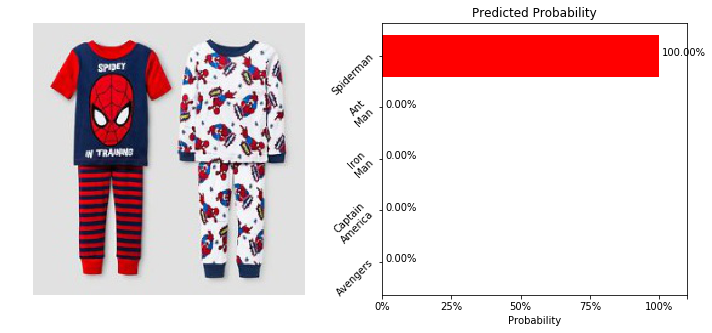

In [47]:
model_vgg16.plot_predict_res(image_id=13, type='M')

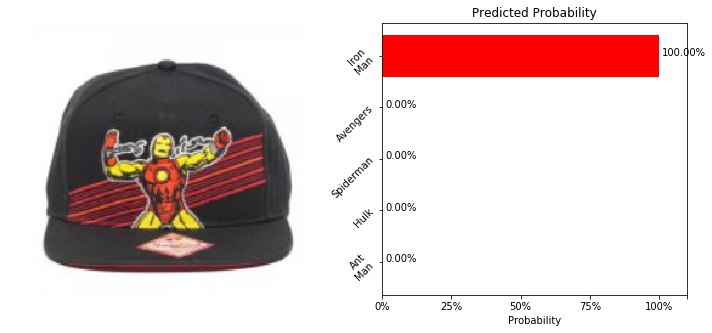

In [27]:
model_vgg16.plot_predict_res(image_id=3, type='M')

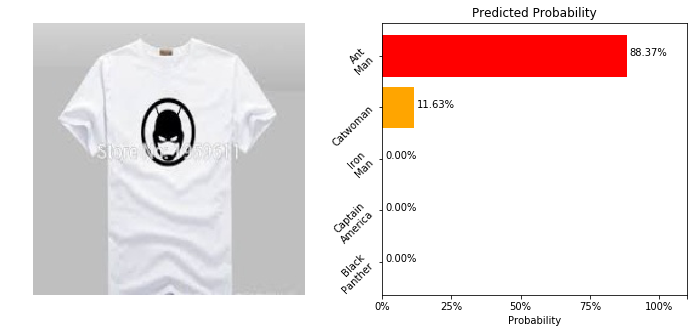

In [38]:
model_vgg16.plot_predict_res(image_id=250, type='M')

## Model Learning: Visualization through Heat Maps

NOTE: The number of images in the table is too large, only 5 randomly selected images are used in analysis.
NOTE: Table IMAGEDATA_AXTEID contains compressed images.


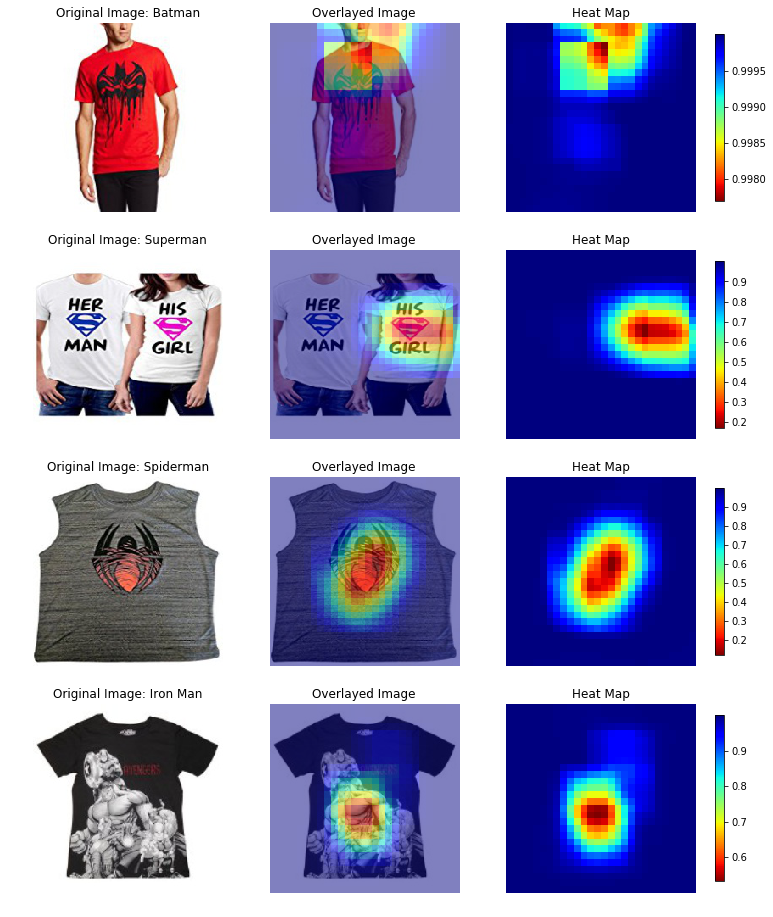

,_filename_0,_image_,_label_,heat_map
0,cax_batman_train1190.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Batman,"[[0.999992132187, 0.999992132187, 0.9999921321..."
1,cax_superman_train4925.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Superman,"[[0.999999523163, 0.999999523163, 0.9999995231..."
2,cax_spiderman_train4327.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Spiderman,"[[0.999822318554, 0.999822318554, 0.9998223185..."
3,cax_ironman_train3748.jpeg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Iron Man,"[[0.998847126961, 0.998847126961, 0.9988471269..."


In [39]:
# Heat Map looks at individual pixels and looks at the impact of removing that pixel to the probability
#  of a correct classification

model_vgg16.heat_map_analysis(data=super_images_train,
                              mask_width=56,
                              mask_height=56,
                              step_size=8)

## Model Learning: Visualization Feature Maps

In [ ]:
model_vgg16.get_feature_maps(data=super_images_train, label='Iron Man', image_id=3)

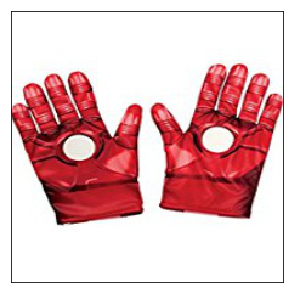

In [52]:
model_vgg16.feature_maps.display(layer_id=0)

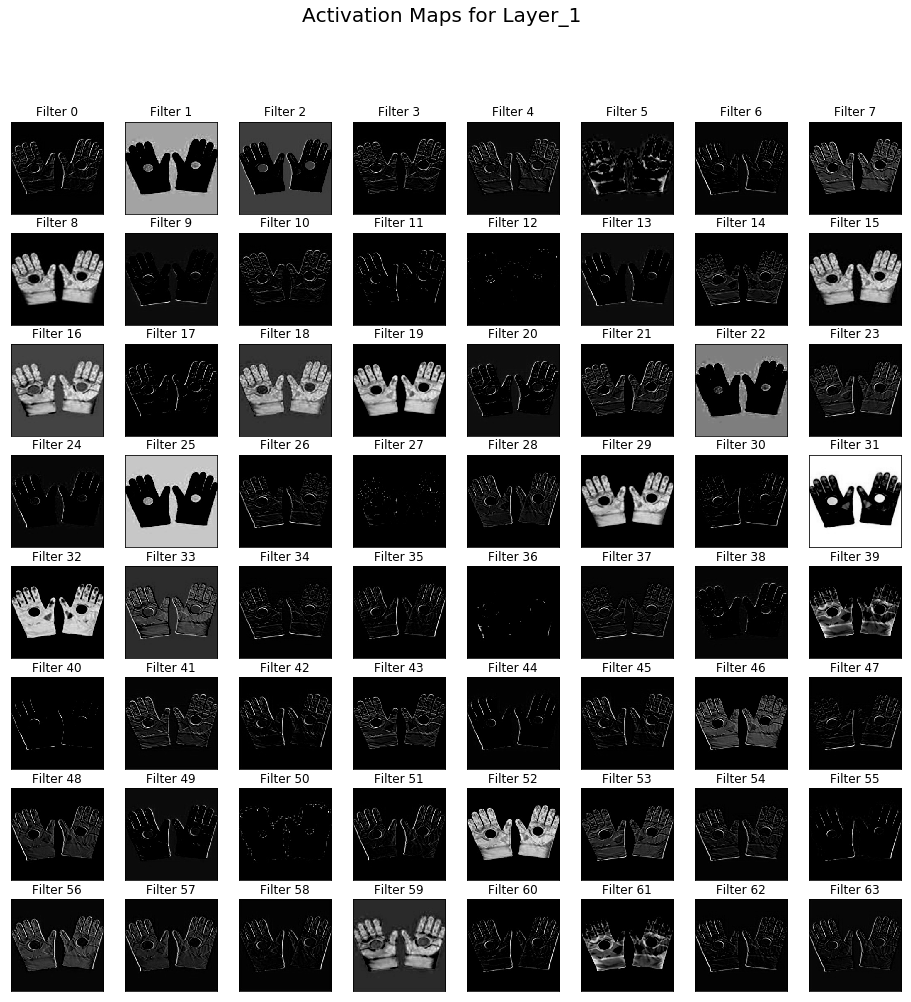

In [53]:
model_vgg16.feature_maps.display(layer_id=1)

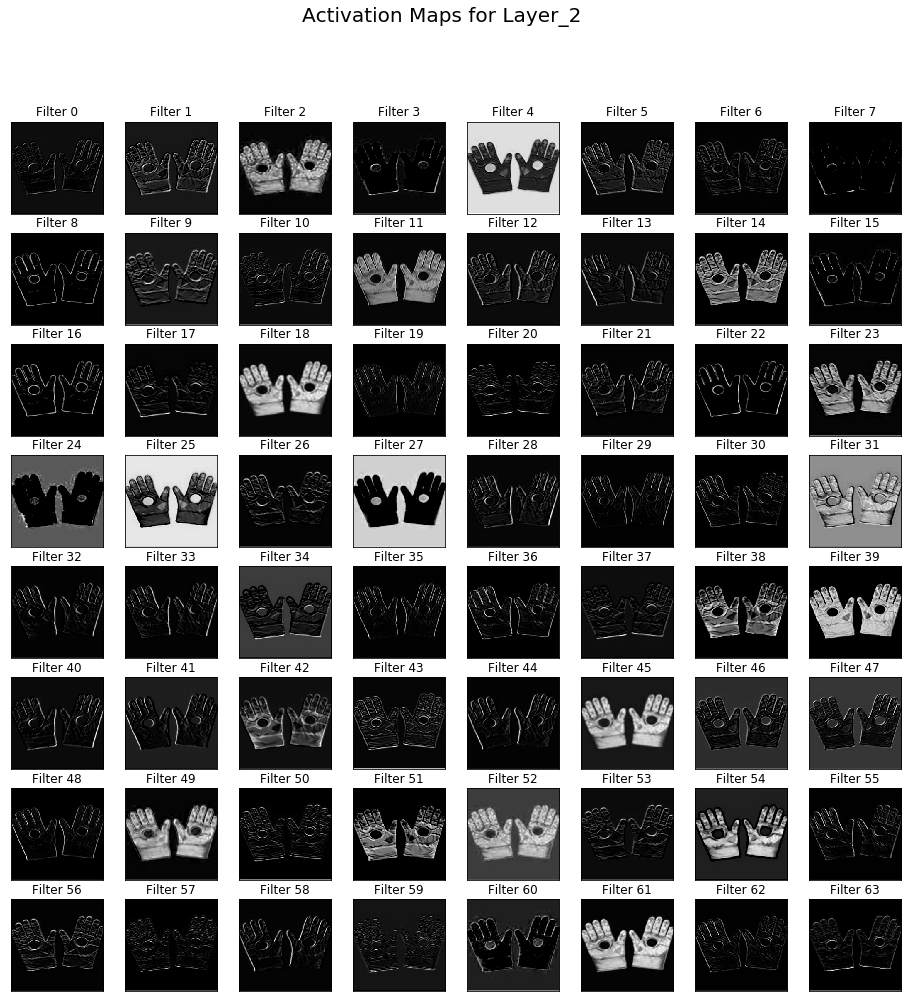

In [54]:
model_vgg16.feature_maps.display(layer_id=2)

## Model Deployment to ASTORE

In [71]:
model_vgg16.deploy(path='/data/andre_data/SAS DL Demo/', output_format='astore')

NOTE: Model astore file saved successfully.


Close Connection

In [72]:
conn.session.endsession()
conn.close()